# SOSE Data - cleaned version
Bottom Temperature and Salinity to compare with ECCOv4r3 and WOA products

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.3:33175")
client

Client Scheduler: tcp://10.32.16.3:33175 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 26 Cores: 52 Memory: 299.00 GB


In [65]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import regionmask
import geopandas

In [3]:
ocean_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ocean_cat = intake.Catalog(ocean_url)
ds = ocean_cat["SOSE"].to_dask()

In [25]:
coords_before_drop = ds.coords.to_dataset().reset_coords().roll(XC=700, XG=700) #ds split into coords
dsr_before_drop = ds.reset_coords(drop=True).roll(XC=700, XG=700) #ds dropping coords so it just holds data variables

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  """Entry point for launching an IPython kernel.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  


In [26]:
dsr = dsr_before_drop.drop(['XC', 'YC', 'XG', 'YG'])
coords = coords_before_drop.drop(['XC', 'YC', 'XG', 'YG'])

In [6]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880

In [7]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

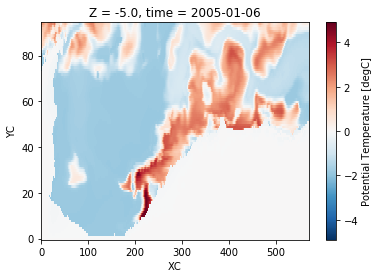

In [8]:
dsr.THETA[0,0].isel(**lat_range, **lon_range).plot()#.drop(['XC', 'YC']).plot()

In [9]:
temp_wg = dsr.THETA.isel(**lat_range, **lon_range)

In [10]:
temp_wg_mean = temp_wg.mean(dim='time')
temp_wg_mean

<xarray.DataArray 'THETA' (Z: 42, YC: 95, XC: 570)>
dask.array<mean_agg-aggregate, shape=(42, 95, 570), dtype=float32, chunksize=(42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
Dimensions without coordinates: YC, XC

In [11]:
#this gives us the depth of the bottom cell
depth_max = dsr.Z.where(temp_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [12]:
depth_max

<xarray.DataArray 'Z' (YC: 95, XC: 570)>
dask.array<nanmax-aggregate, shape=(95, 570), dtype=float32, chunksize=(95, 570), chunktype=numpy.ndarray>
Dimensions without coordinates: YC, XC

In [13]:
bottom_temp = temp_wg_mean.sel(Z=depth_max.fillna(0.))

In [14]:
bottom_temp.load()

<xarray.DataArray 'THETA' (YC: 95, XC: 570)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.59500206,  0.59372324,  0.5860209 , ..., -0.61448747,
        -0.61401767, -0.6136384 ],
       [ 0.7132437 ,  0.7120261 ,  0.7027545 , ..., -0.5988263 ,
        -0.59873897, -0.5980881 ],
       [ 0.8445248 ,  0.8352686 ,  0.8186579 , ..., -0.57839876,
        -0.5790265 , -0.5787111 ]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
Dimensions without coordinates: YC, XC

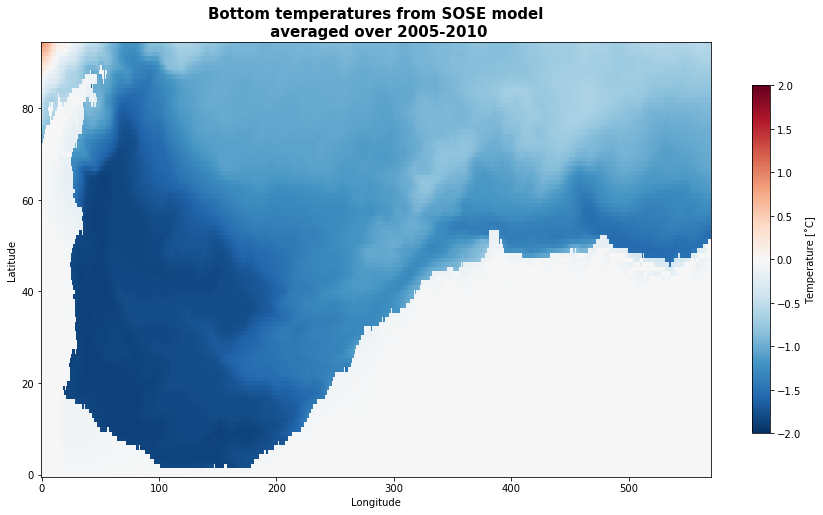

In [15]:
bottom_temp.plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, cmap='RdBu_r', vmax=2)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from SOSE model\n averaged over 2005-2010', fontsize=15, weight='bold');

In [16]:
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0).load()

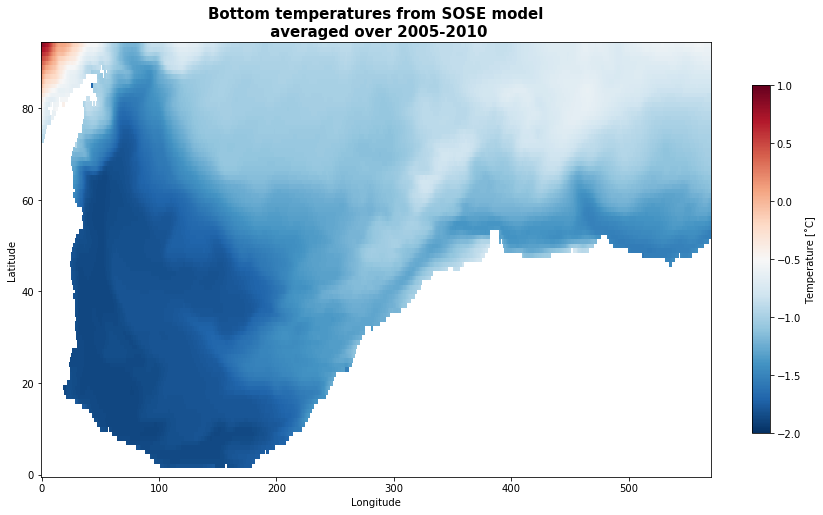

In [17]:
bottom_temp.where(surface_mask).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, cmap='RdBu_r', vmin=-2, vmax=1)

#plt.xticks(labels=(-65, -50, -35, -20, -5, 25))
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from SOSE model\n averaged over 2005-2010', fontsize=15, weight='bold');

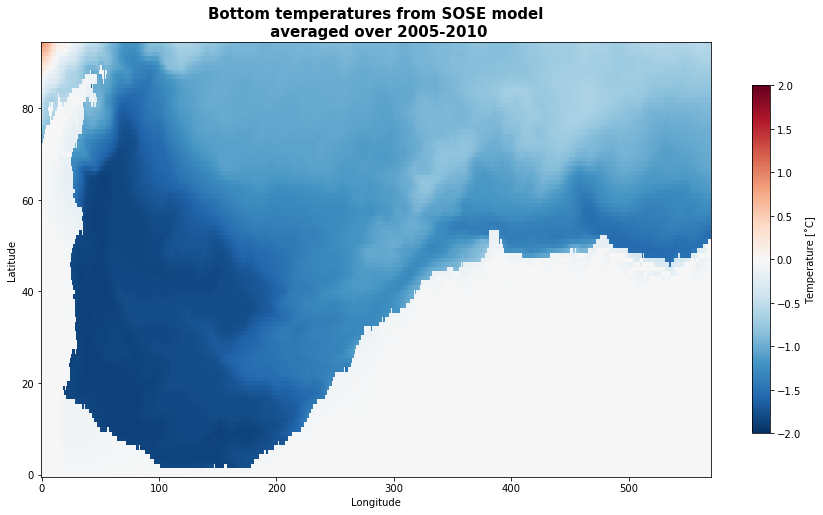

In [82]:
bottom_temp.where(depth_max).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, cmap='RdBu_r', vmin=-2, vmax=2)

#plt.xticks(labels=(-65, -50, -35, -20, -5, 25))
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from SOSE model\n averaged over 2005-2010', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

In [29]:
lon = coords_before_drop.XC.isel(**lon_range)
lat = coords_before_drop.YC.isel(**lat_range)

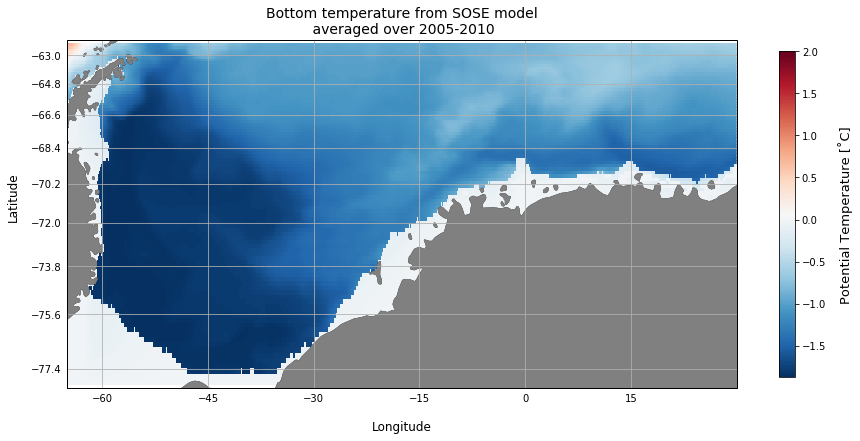

In [88]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_temp, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from SOSE model\n averaged over 2005-2010', fontsize=14);

## BOTTOM SALT

In [32]:
slt_wg = dsr.SALT.isel(**lat_range, **lon_range)

In [33]:
slt_wg_mean = slt_wg.mean(dim='time')
slt_wg_mean

<xarray.DataArray 'SALT' (Z: 42, YC: 95, XC: 570)>
dask.array<mean_agg-aggregate, shape=(42, 95, 570), dtype=float32, chunksize=(42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
Dimensions without coordinates: YC, XC

In [34]:
#this gives us the depth of the bottom cell
depth_max_slt = dsr.Z.where(slt_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [35]:
bottom_slt = slt_wg_mean.sel(Z=depth_max_slt.fillna(0.)).load()

In [36]:
bottom_slt

<xarray.DataArray 'SALT' (YC: 95, XC: 570)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [33.708538, 33.709415, 33.709522, ..., 33.853043, 33.854958,
        33.856647],
       [33.72277 , 33.723537, 33.72321 , ..., 33.855934, 33.8571  ,
        33.858185],
       [33.741817, 33.74131 , 33.739555, ..., 33.85897 , 33.859295,
        33.85984 ]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
Dimensions without coordinates: YC, XC

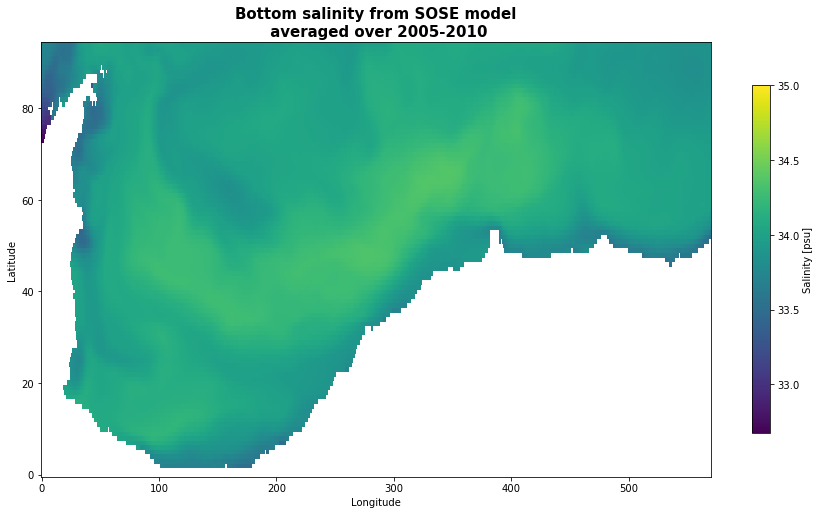

In [37]:
bottom_slt.where(surface_mask).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Salinity [psu]'}, vmax=35)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom salinity from SOSE model\n averaged over 2005-2010', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

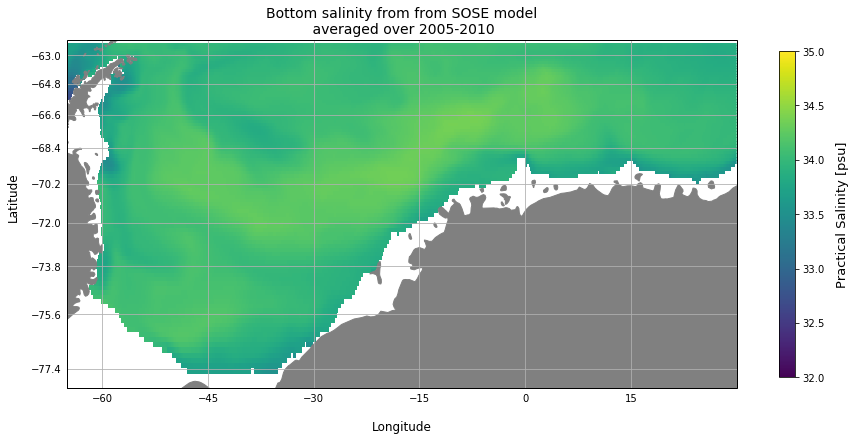

In [87]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_slt.where(surface_mask), transform=ccrs.PlateCarree(), vmin=32, vmax=35, cmap='viridis')

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Practical Salinity [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from from SOSE model\n averaged over 2005-2010', fontsize=14, );